In [14]:
import psycopg2
import pandas as pd

connection = psycopg2.connect(
    host="localhost",     
    database="postgres",   
    user="postgres",     
    password="0000",  
    port="5432"       
)

cursor = connection.cursor()
cursor.execute("SELECT version();")

db_version = cursor.fetchone()
print("PostgreSQL version:", db_version)

query = """
SELECT *
FROM weather_data
WHERE aws is not null AND EXTRACT(month FROM date) = 4
ORDER BY row, col ASC;
"""


df = pd.read_sql(query, connection)

cursor.close()
connection.close()

PostgreSQL version: ('PostgreSQL 17.0 on x86_64-windows, compiled by msvc-19.41.34120, 64-bit',)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\3878433759.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [15]:
average_precipitation = df['aws'].mean()
print(f"Average rainfall in October: {average_precipitation:.4f}")

Average rainfall in October: 0.1411


## Loại bỏ giá trị bị thiếu
Cột nào nhiều null quá thì bỏ để tránh mất dữ liệu row của aws

In [16]:
# Drop bcs these columns contain too many null values.
# For attributes 'kx', perhaps try to interpolate the missing values since this attribute may play an important role.
# tho i'm not sure bc 15% of the data went missing-- the percentage is siginificantly large.
columns_to_drop = ['v250', 'ie', 'sshf', 'ewss', 'pev', 'slhf', 'b06b', 'u850', 'v850', 'u250', 'b04b', 'vsb', 'b05b', 'radar', 'r250', 'kx']
df = df.drop(columns=columns_to_drop)

columns_with_null = df.columns[df.isnull().any()].tolist()

num_columns_with_null = len(columns_with_null)
print("Number of columns with null values:", num_columns_with_null)

null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(null_counts)

df = df.dropna()
print(df.shape)

# Rainfall classification: page 484 https://library.wmo.int/viewer/68695/download?file=8_I-2023_en.pdf&type=pdf&navigator=1
conditions = {
    'No Rain': (df['aws'] == 0.0),
    'Slight Rain': (df['aws'] > 0) & (df['aws'] < 2.5),
    'Moderate Rain': (df['aws'] >= 2.5) & (df['aws'] <= 10.0),
    'Heavy Rain': (df['aws'] > 10.0) & (df['aws'] <= 50),
    'Intense Rain': (df['aws'] > 50)
}

rain_counts = {}

for label, condition in conditions.items():
    count = df[condition].shape[0]  
    rain_counts[label] = count

for label, count in rain_counts.items():
    print(f"{label}: {count}")

df = df.sort_values(by=['row', 'col', 'date'])
df.reset_index(drop=True, inplace=True)

Number of columns with null values: 10
b14b    29178
b12b    28939
wvb     29655
b10b    28939
i4b     50989
b11b    28939
i2b     29178
b09b    28939
b16b    29178
irb     29178
dtype: int64
(254147, 24)
No Rain: 234275
Slight Rain: 17301
Moderate Rain: 1949
Heavy Rain: 592
Intense Rain: 30


## Phân cụm
Đoạn này chỉ phân cụm theo pixel vì t thực nghiệm bằng random forest thấy SLOR và ISOR (vốn là hai tham số liên quan đến địa hình) không có ý nghĩa lắm. 
Số cụm được chọn dựa trên mấy bản tin dự báo thời tiết (thường chia thành 4-5 khu vực) + elbow method.

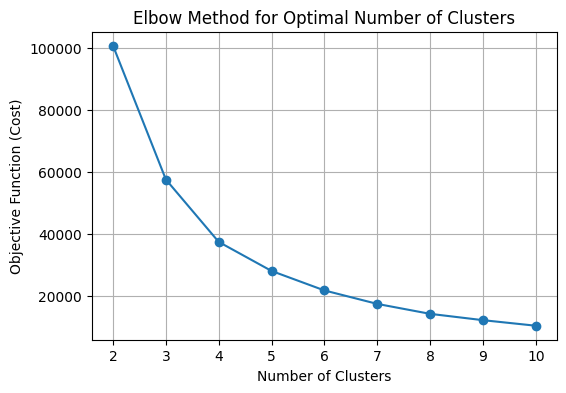

In [17]:
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_mean_pixel = df.groupby(['row', 'col']).mean().reset_index()
df_mean_pixel['col'] = np.clip(df_mean_pixel['col'], 40, None)  
df_mean_pixel['col'] = np.clip(df_mean_pixel['col'], None, 160)

cluster_data = df_mean_pixel[['row', 'col']].T  

jm_values = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        cluster_data, n_clusters, 2, error=0.005, maxiter=1000, init=None)
    
    jm_values.append(jm[-1]) 

plt.figure(figsize=(6, 4))
plt.plot(cluster_range, jm_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Objective Function (Cost)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

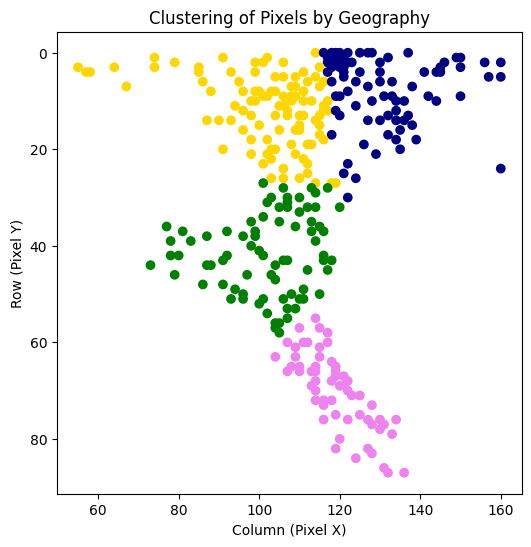

Cluster 0 has color navy
Cluster 1 has color gold
Cluster 2 has color green
Cluster 3 has color violet
Cluster 4 has color indigo
Cluster 5 has color lime
Cluster 6 has color red


In [18]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

cluster_colors = {0: 'navy', 1: 'gold', 2: 'green', 3: 'violet', 4: 'indigo', 5: 'lime', 6: 'red'}

n_clusters = 4

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(cluster_data, n_clusters, 2, error=0.005, maxiter=1000, init=None)

cluster_labels = np.argmax(u, axis=0)
df_mean_pixel['Cluster'] = cluster_labels

sorted_indices = np.argsort(cntr[:, 0])  
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
df_mean_pixel['Cluster'] = [cluster_mapping[label] for label in cluster_labels]

colors = [cluster_colors[label] for label in df_mean_pixel['Cluster']]

plt.figure(figsize=(6, 6))
plt.scatter(df_mean_pixel['col'], df_mean_pixel['row'], c=colors)
plt.xlabel('Column (Pixel X)')
plt.ylabel('Row (Pixel Y)')
plt.title('Clustering of Pixels by Geography')
plt.gca().invert_yaxis()
plt.show()

for cluster, color in cluster_colors.items():
    print(f'Cluster {cluster} has color {color}')


In [19]:
df_combined = pd.merge(df, df_mean_pixel[['row', 'col', 'Cluster']], on=['row', 'col'], how='inner')
if 'Cluster' in df_combined.columns:
    aws_stats_by_cluster = df_combined.groupby('Cluster')['aws'].agg(['mean', 'min', 'max']).round(4)
    print(aws_stats_by_cluster)

    conditions = {
        'Slight Rain': (df_combined['aws'] < 2.5),
        'Moderate Rain': (df_combined['aws'] >= 2.5) & (df_combined['aws'] <= 10.0),
        'Heavy Rain': (df_combined['aws'] > 10.0) & (df_combined['aws'] <= 50),
        'Intense Rain': (df_combined['aws'] > 50)
    }

    rain_stats_by_cluster = pd.DataFrame()

    for label, condition in conditions.items():
        count_by_cluster = df_combined[condition].groupby('Cluster').size()
        rain_stats_by_cluster[label] = count_by_cluster

    rain_stats_by_cluster = rain_stats_by_cluster.fillna(0).astype(int)

    print("\nCombined table of rain statistics per cluster:")
    print(rain_stats_by_cluster)
else:
    print("Column 'Cluster' not found in the merged DataFrame.")


           mean  min    max
Cluster                    
0        0.0961  0.0   45.6
1        0.1342  0.0   41.8
2        0.0788  0.0   85.9
3        0.2022  0.0  113.6

Combined table of rain statistics per cluster:
         Slight Rain  Moderate Rain  Heavy Rain  Intense Rain
Cluster                                                      
0              79529            480         171             0
1              77946            870         200             0
2              49954            249          77             2
3              42660            344         144            28


## Xử lý outliers

In [20]:
import pandas as pd
from sklearn.ensemble import IsolationForest

if 'Cluster' in df_combined.columns:
    outlier_stats = []
    max_values_by_cluster = {}

    for cluster, group in df_combined.groupby('Cluster'):
        aws_values = group['aws'][group['aws'] > 0]

        if aws_values.empty:
            continue  

        heavy_rain_count = (aws_values > 10.0).sum()
        total_count = len(aws_values)
        contamination_ratio = heavy_rain_count / total_count if total_count > 0 else 0
        # more heavy rains in cluster 3 (the Central VN) than in other regions so i'm not sure abt this
        # firstly let's just naively assume we shouldn't let outliers account for > 10% of the data
        # bcs when i use the IQR techniqe to detect outliers, no cluster has more than 10% of data as outliers.
        iso_forest = IsolationForest(contamination=min(0.1,contamination_ratio), random_state=42)  

        aws_values_reshaped = aws_values.values.reshape(-1, 1)
        iso_forest.fit(aws_values_reshaped)
        outlier_predictions = iso_forest.predict(aws_values_reshaped)
        non_outliers = aws_values[outlier_predictions != -1]  
        outliers = aws_values[outlier_predictions == -1] 
        outlier_percentage = (len(outliers) / len(aws_values)) * 100
        
        min_value = non_outliers.min() if len(non_outliers) > 0 else None
        max_value = non_outliers.max() if len(non_outliers) > 0 else None

        if max_value is not None:
            max_values_by_cluster[cluster] = max_value
        
        outlier_stats.append({
            'Cluster': cluster,
            'Outlier_Percentage': round(outlier_percentage, 4),
            'Lower bound': round(min_value, 4) if min_value is not None else None,
            'Upper bound': round(max_value, 4) if max_value is not None else None
        })

        # clipping method: set the values of the outliers to the upper bound
        # as storms can likely be predictive,
        # for all values greater than upper_bound, treat them as if we're predicting storms
        df_combined['aws'] = np.where(df_combined['aws']>max_value, max_value, df_combined['aws'])

    outlier_stats_df = pd.DataFrame(outlier_stats)
    print("\nOutlier statistics for each cluster using Isolation Forest:")
    print(outlier_stats_df)
else:
    print("Column 'Cluster' not found in the merged DataFrame.")


Outlier statistics for each cluster using Isolation Forest:
   Cluster  Outlier_Percentage  Lower bound  Upper bound
0        0              3.1324         0.05         10.4
1        1              2.7281         0.02         10.0
2        2              2.4107         0.02         11.4
3        3              4.6612         0.01         10.0


In [21]:
from sqlalchemy import create_engine

db_credentials = {
    'user': 'postgres', 
    'password': '0000',  
    'host': 'localhost',  
    'port': '5432',      
    'database': 'postgres'        
}

connection_string = f"postgresql+psycopg2://{db_credentials['user']}:{db_credentials['password']}@{db_credentials['host']}:{db_credentials['port']}/{db_credentials['database']}"

engine = create_engine(connection_string)

try:
    df_combined.to_sql('extracted_weather_data', engine, if_exists='replace', index=False)
    print("DataFrame saved to database successfully.")
except Exception as e:
    print(f"Error: {e}")

DataFrame saved to database successfully.


In [22]:
from sqlalchemy import text

with open("SQL queries/extract_data.sql", "r") as file:
    sql_query = file.read()

with engine.connect() as connection:
    result = connection.execute(text(sql_query))
    rows = result.fetchall()
    columns = result.keys()

df = pd.DataFrame(rows, columns=columns)

df.to_csv('csv samples/extracted_weather_data_4.csv', index=False)
print("Data saved to 'extracted_weather_data_4.csv'.")

Data saved to 'extracted_weather_data_4.csv'.


## Huấn luyện mô hình
1. **Phân loại mưa/không mưa:**
- Sử dụng `train_test_split` một lần để phân chia tập train/test cho cả hai bước. Sau đó thực hiện phân loại để dự đoán có mưa hay không.
- Trước khi train sử dụng SMOTE để oversampling số lượng dữ liệu có mưa tránh overfitting (vì tỉ lệ chênh lệch giữa mưa/không mưa quá lớn).
2. **Hồi quy dự đoán lượng mưa:**
- Loại bỏ các hàng có giá trị "AWS+1h" bằng 0 trong tập train và test để huấn luyện mô hình hồi quy, cũng để tránh overfitting.
3. **Kết hợp kết quả hai bước trên:** 
- Gán giá trị lượng mưa bằng 0 cho các hàng mà phân loại dự đoán là "không mưa". Sau đó, tính toán các metric đánh giá bao gồm cả các hàng "không mưa".

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
import numpy as np
from imblearn.combine import SMOTEENN

def weighted_average(metric_values, cluster_sizes):
    total_samples = sum(cluster_sizes) 
    weighted_avg_value = sum(value * size for value, size in zip(metric_values, cluster_sizes)) / total_samples
    return weighted_avg_value

data = pd.read_csv('csv samples/extracted_weather_data_4.csv')

### Huấn luyện mô hình sau khi đã chia cụm

In [24]:
import os

classification_models = {}
regression_models = {}
cluster_mses = []
cluster_mses_only_rain = []
cluster_accuracies = []
cluster_f1_scores = []
cluster_sizes = []

predictions = {}

os.makedirs("results/results_4", exist_ok=True)

for filename in ["classifier_comparison.txt", "metrics_comparison.txt"]:
    with open(f"results/results_4/{filename}", "w") as file:
        pass  

In [25]:
for cluster in data['Cluster'].unique():
    print(f"Processing Cluster {cluster}")
    cluster_df = data[data['Cluster'] == cluster]
    results_df = pd.DataFrame()

    for time_step in [1, 3, 6]:
        cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
        rain_count = cluster_df['AWS_binary'].value_counts()
        no_rain_ratio = rain_count.get(0, 0) / len(cluster_df)
        rain_ratio = rain_count.get(1, 0) / len(cluster_df)

        class_weight = {0: rain_ratio, 1: no_rain_ratio}
        X = cluster_df.drop(columns=['date', 'row', 'col', 'Cluster', 'AWS_binary'])
        y = cluster_df['AWS_binary']
        X = X.drop(columns=[f'AWS+{i}h' for i in [1, 3, 6] if i >= time_step])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        original_X_train = X_train

        if rain_count.get(0, 0) / rain_count.get(1, 1) < 0.67:
            smote_enn = SMOTEENN(sampling_strategy=0.67, random_state=42)
            X_train, y_train = smote_enn.fit_resample(X_train, y_train)

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)
        xgb_classifier = XGBClassifier(random_state=42, scale_pos_weight=class_weight[1] / class_weight[0])

        rf_classifier.fit(X_train, y_train)
        xgb_classifier.fit(X_train, y_train)

        y_pred_rf = rf_classifier.predict(X_test)
        y_pred_xgb = xgb_classifier.predict(X_test)

        f1_rf = f1_score(y_test, y_pred_rf)
        accuracy_rf = accuracy_score(y_test, y_pred_rf)

        f1_xgb = f1_score(y_test, y_pred_xgb)
        accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

        if f1_rf >= f1_xgb:
            classifier = rf_classifier
            f1 = f1_rf
            accuracy = accuracy_rf
            chosen_model = "Random Forest"
        else:
            classifier = xgb_classifier
            f1 = f1_xgb
            accuracy = accuracy_xgb
            chosen_model = "XGBoost"

        with open("results/results_4/classifier_comparison.txt", "a") as file:
            file.write(f"Cluster {cluster} timestep {time_step} - Random Forest - F1 score: {f1_rf:.4f}, Accuracy: {accuracy_rf:.4f}\n")
            file.write(f"Cluster {cluster} timestep {time_step} - XGBoost - F1 score: {f1_xgb:.4f}, Accuracy: {accuracy_xgb:.4f}\n")
            file.write(f"Cluster {cluster} timestep {time_step} - Chosen model: {chosen_model}\n\n")

        classification_models[cluster] = classifier

        cluster_accuracies.append(accuracy)
        cluster_f1_scores.append(f1)
        cluster_sizes.append(len(y_test))

        feature_importances = classifier.feature_importances_
        top_10_features = X.columns[np.argsort(feature_importances)[-10:]]

        X_train_reg = X_train[top_10_features]
        X_test_reg = X_test[top_10_features]
        
        train_rain_idx = np.where(y_train != 0)[0]
        test_rain_idx = np.where(y_test != 0)[0]

        valid_train_rain_idx = [i for i in train_rain_idx if i < len(original_X_train)]
        X_train_reg_rain = original_X_train.iloc[valid_train_rain_idx]
        y_train_reg_rain = cluster_df.loc[original_X_train.index[valid_train_rain_idx], f'AWS+{time_step}h']
        
        X_test_reg_rain = X_test.iloc[test_rain_idx]
        y_test_reg_rain = cluster_df.loc[X_test.index[test_rain_idx], f'AWS+{time_step}h']

        model = MLPRegressor(solver='adam', hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42)
        model.fit(X_train_reg_rain, y_train_reg_rain)
        regression_models[cluster] = model

        y_pred_reg = np.round(np.clip(model.predict(X_test_reg_rain), 0.1, max(max_values_by_cluster[cluster], 10.0)), 4)
        y_pred_reg_adjusted = np.zeros(len(y_test))
        y_pred_reg_adjusted[test_rain_idx] = y_pred_reg
        
        y_test_combined = cluster_df[f'AWS+{time_step}h'].loc[X_test.index]
        predictions[time_step] = np.round(y_pred_reg_adjusted, 4)

        mse = np.sqrt(mean_squared_error(y_test_combined, y_pred_reg_adjusted))
        mse_only_rain = np.sqrt(mean_squared_error(y_test_reg_rain, y_pred_reg)) if len(test_rain_idx) > 0 else None

        cluster_mses.append(mse)
        cluster_mses_only_rain.append(mse_only_rain)

        results_df[f'Actual AWS+{time_step}h'] = y_test_combined
        results_df[f'Predicted AWS+{time_step}h'] = predictions[time_step]

        with open(f"results/results_4/metrics_comparison.txt", "a") as file:
            file.write(f"Cluster {cluster} timestep {time_step} - F1 score: {f1:.4f}\n")
            file.write(f"Cluster {cluster} timestep {time_step} - Regression mse: {mse:.4f}\n")

    results_df.to_csv(f'results/results_4/results_for_cluster_{cluster}.csv', index=False)

weighted_mse_value = weighted_average(cluster_mses, cluster_sizes)
weighted_mse_rain_value = weighted_average(cluster_mses_only_rain, cluster_sizes)
weighted_accuracy_value = weighted_average(cluster_accuracies, cluster_sizes)
weighted_f1_value = weighted_average(cluster_f1_scores, cluster_sizes)

print(f"Average MSE across all clusters: {weighted_mse_value:.4f}")
print(f"Average MSE (Rain Only): {weighted_mse_rain_value:.4f}")
print(f"Average Accuracy across all clusters: {weighted_accuracy_value:.4f}")
print(f"Average F1 Score across all clusters: {weighted_f1_value:.4f}")

Processing Cluster 1


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is

Processing Cluster 0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is

Processing Cluster 2


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is

Processing Cluster 3


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['AWS_binary'] = cluster_df[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24972\55224409.py:7: SettingWithCopyWarning: 
A value is

Average MSE across all clusters: 0.6540
Average MSE (Rain Only): 2.3475
Average Accuracy across all clusters: 0.9176
Average F1 Score across all clusters: 0.5587


### Huấn luyện mô hình khi không chia cụm

In [26]:
mses = []
mses_only_rain = []
accuracies = []
f1_scores = []
test_sizes = []

In [27]:
results_df = pd.DataFrame()

for time_step in [1, 3, 6]:
    data['AWS_binary'] = data[f'AWS+{time_step}h'].apply(lambda x: 0 if x == 0 else 1)

    rain_count = data['AWS_binary'].value_counts()
    no_rain_ratio = rain_count[0] / len(data) if 0 in rain_count else 0
    rain_ratio = rain_count[1] / len(data) if 1 in rain_count else 0

    class_weight = {0: rain_ratio, 1: no_rain_ratio}

    X = cluster_df.drop(columns=['date', 'row', 'col', 'Cluster', 'AWS_binary'])  
    y = cluster_df['AWS_binary']  
    X = X.drop(columns=[f'AWS+{i}h' for i in [1, 3, 6] if i >= time_step])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    original_X_train = X_train
    if (rain_count[0] / rain_count[1] < 0.67):
        smote_enn = SMOTEENN(sampling_strategy=0.67, random_state=42)
        X_train, y_train = smote_enn.fit_resample(X_train, y_train)

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)
    xgb_classifier = XGBClassifier(random_state=42, scale_pos_weight=class_weight[1] / class_weight[0])

    rf_classifier.fit(X_train, y_train)
    xgb_classifier.fit(X_train, y_train)

    y_pred_rf = rf_classifier.predict(X_test)
    y_pred_xgb = xgb_classifier.predict(X_test)

    f1_rf = f1_score(y_test, y_pred_rf)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)

    f1_xgb = f1_score(y_test, y_pred_xgb)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

    if f1_rf >= f1_xgb:
        classifier = rf_classifier
        f1 = f1_rf
        accuracy = accuracy_rf
        chosen_model = "Random Forest"
    else:
        classifier = xgb_classifier
        f1 = f1_xgb
        accuracy = accuracy_xgb
        chosen_model = "XGBoost"

    with open("results/results_4/classifier_comparison.txt", "a") as file:
        file.write(f"Timestep {time_step} - Random Forest - F1 score: {f1_rf:.4f}, Accuracy: {accuracy_rf:.4f}\n")
        file.write(f"Timestep {time_step} - XGBoost - F1 score: {f1_xgb:.4f}, Accuracy: {accuracy_xgb:.4f}\n")
        file.write(f"Timestep {time_step} - Chosen model: {chosen_model}\n\n")

    classification_models[cluster] = classifier

    y_pred_binary = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)  

    accuracies.append(accuracy)
    f1_scores.append(f1)
    test_sizes.append(len(y_test))

    feature_importances = classifier.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    top_10_features = importance_df['Feature'].head(10).values
    X_train_reg = X_train[top_10_features]
    X_test_reg = X_test[top_10_features]

    train_indices_with_rain = np.where(y_train != 0)[0]
    test_indices_with_rain = np.where(y_test != 0)[0]

    valid_train_indices_with_rain = [i for i in train_indices_with_rain if i < len(original_X_train)]

    X_train_reg_rain = original_X_train.iloc[valid_train_indices_with_rain]
    y_train_reg_rain = data.loc[original_X_train.index[valid_train_indices_with_rain], f'AWS+{time_step}h']

    X_test_reg_rain = X_test.iloc[test_indices_with_rain]
    y_test_reg_rain = data.loc[X_test.index[test_indices_with_rain], f'AWS+{time_step}h']

    model = MLPRegressor(solver='adam', hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)
    model.fit(X_train_reg_rain, y_train_reg_rain)
    regression_model = model

    y_pred_reg = model.predict(X_test_reg_rain)

    max_value = max(max_values_by_cluster[cluster], float(10.0))
    y_pred_reg = np.clip(y_pred_reg, 0.1, max_value)

    y_pred_reg_adjusted = np.zeros(len(y_pred_binary))
    y_pred_reg_adjusted[test_indices_with_rain] = y_pred_reg

    y_test_combined = data[f'AWS+{time_step}h'].loc[X_test.index]
    mse = np.sqrt(mean_squared_error(y_test_combined, y_pred_reg_adjusted))
    mse_only_rain = np.sqrt(mean_squared_error(y_test_reg_rain, y_pred_reg)) if len(test_indices_with_rain) > 0 else None
      
    predictions[time_step] = np.round(y_pred_reg_adjusted, 4)
    mses.append(mse)
    mses_only_rain.append(mse_only_rain)
    
    results_df[f'Actual AWS+{time_step}h'] = y_test_combined
    results_df[f'Predicted AWS+{time_step}h'] = predictions[time_step]

    with open(f"results/results_4/metrics_comparison.txt", "a") as file:
        file.write(f"Timestep {time_step} - F1 score: {f1:.4f}\n")
        file.write(f"Timestep {time_step} - Regression mse: {mse:.4f}\n")

results_df.to_csv(f'results/results_4/results_no_cluster.csv', index=False)

weighted_mse_value = weighted_average(mses, test_sizes)
weighted_mse_rain_value = weighted_average(mses_only_rain, test_sizes)
weighted_accuracy_value = weighted_average(accuracies, test_sizes)
weighted_f1_value = weighted_average(f1_scores, test_sizes)

print(f"Accuracy: {weighted_accuracy_value:.4f}")
print(f"F1 score: {weighted_f1_value:.4f}")
print(f"MSE: {weighted_mse_value:.4f}")
print(f"MSE (Rain Only): {weighted_mse_rain_value:.4f}")

Accuracy: 0.9180
F1 score: 0.5630
MSE: 0.6895
MSE (Rain Only): 1.9493
